# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [117]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [118]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
from correlade import correlade
import distcorr
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import ast
import pdb

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [119]:
# Import vec file
with open('../../opa2vec/outter.lst', 'r') as file:
    text = file.read()

# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [120]:
df.sample(13)

,ID,Vector
6511,D000255,"[-0.09476919, 0.13179843, 0.2179865, -0.346723..."
1155,MESH:C563801-p,"[-5.71336299e-02, 4.66678739e-02, 5.42178862e-..."
11928,D005034,"[-0.05555808, 0.05272527, 0.06770945, -0.11169..."
12602,C004984-n,"[-0.06776077, 0.00714859, 0.14182633, -0.24546..."
589,MESH:D006463-p,"[-4.59904820e-02, 1.39874369e-01, 8.21784213e-..."
4394,MESH:D015663-n,"[-0.06028654, 0.05314248, 0.04262458, -0.12095..."
3371,MESH:D007984-p,"[-0.03950234, 0.06167218, 0.04151897, -0.12157..."
18859,D012314,"[-5.79285324e-02, 4.93040867e-02, 5.59226386e-..."
2645,MESH:C537194-p,"[-3.50516438e-02, 7.78730810e-02, 4.39822190e-..."
9351,D001514-n,"[-0.08390208, 0.04317693, 0.10903978, -0.27251..."


In [121]:
# # # Create a df template
df2 = pd.DataFrame(columns=['ID','DisDirCorrVec', 'DisInvCorrVec', 'ChemDirCorrVec',
                            'ChemInvCorrVec', 'ChemUnspecCorrVec'])

In [122]:
# Move info over
def is_dis(stringer):
    if ('MESH' in stringer) or ('OMIM' in stringer):
        return True
    else:
        return False

In [123]:
df2['ID'] = df.ID.copy()
df2['ID'] = df2.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))
df2 = df2.drop_duplicates()

In [124]:
# # df2[df2.DisDirCorrVec]
# import pdb

In [125]:
# for index, row in df.iterrows():
#     if is_dis(row.ID):
#         if '-p' in row.ID:
#             pdb.set_trace()
#             df2[df2.ID == row.ID.replace('-p','')].iloc[0]['DisDirCorrVec'] = np.array(row.Vector)
#         else:
#             df2[df2.ID == row.ID.replace('-n', '')].iloc[0].DisInvCorrVec = row.Vector
# #     else:
# #         if '-p' in row.ID:
# #             df2.ChemDirCorrVec = row.Vector
# #         elif '-n' in row.ID:
# #             df2.ChemInvCorrVec = row.Vector
# #         else:
# #             df2.ChemUnspecCorrVec = row.vector

    
# # for index, row in df.iterrows():
# #         subj = '<' + subj_url + row[subj_col] + '> '
# #         if row.pred_code == 'nan':
# #             pred = '<' + 'http://ian.ie/' + row[pred_col] + '> '
# #         else:
# #             pred = '<' + 'http://purl.obolibrary.org/obo/' + row['pred_code'] + '> '
# #         if odd_url[0] in row[obj_col]:
# #             row[obj_col] = row[obj_col].replace(odd_url[0], '')
# #             obj = '<' + odd_url[1] + row[obj_col] + '> '
# #         else:
# #             obj = '<' + obj_url + row[obj_col] + '> '
# #         f.write(subj + pred + obj + '.' + '\n')

In [126]:
# df2.loc[df2.ID =='MESH:D058186'].DisInvCorrVec.iloc[0] = 1

In [127]:
# df2.head()

In [128]:
# def moving_stuff (row):
#     if is_dis(df.DirCorr) and ('-p' in df.DirCorr):
#         df2

In [129]:
# mask = is_dis(df.DirCorr) and ('-p' in df.DirCorr)
# df.loc[mask, 'DirCorr'] = df.Vector

In [130]:
# df.groupby('Vector').sum()

In [131]:
# aggregation_functions = {'price': 'sum', 'amount': 'sum', 'name': 'first'}
# df_new = df.groupby(df['id']).aggregate(aggregation_functions)

In [132]:
# # Remove the -p /-n tags (pos/neg correlation) and add them as columns
# df['DirCorr'] = df.ID.map(lambda x: 1 if '-p' in x else 0)
# df['InvCorr'] = df.ID.map(lambda x: 1 if '-n' in x else 0)
# df['UnspecCorr'] = df.DirCorr + df.InvCorr
# df['UnspecCorr'] = df.UnspecCorr.map(lambda x: 0 if x == 1 else 1)

# df['ID'] = df.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))

In [133]:
# Remove the -p /-n tags (pos/neg correlation) and add them as columns
df['DisDirCorrVec'] = df.ID.map(lambda x: 1 if ('-p' in x and is_dis(x)) else 0)
df['DisInvCorrVec'] = df.ID.map(lambda x: 1 if ('-n' in x) and is_dis(x) else 0)
df['ChemDirCorrVec'] = df.ID.map(lambda x: 1 if ('-p' in x) and not is_dis(x) else 0)
df['ChemInvCorrVec'] = df.ID.map(lambda x: 1 if ('-n' in x) and not is_dis(x) else 0)
df['ChemUnspecVec'] = df.DisDirCorrVec + df.DisInvCorrVec + df.ChemDirCorrVec + df.ChemInvCorrVec
df['ChemUnspecVec'] = df.ChemUnspecVec.map(lambda x: 0 if x > 0 else 1)

df['ID'] = df.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))

In [134]:
df.ID[1]

'MESH:D018248'

In [135]:
df.sample(7)

,ID,Vector,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecVec
8500,D000841,"[-9.28096175e-02, 5.16020134e-02, 1.73031196e-...",0,0,0,1,0
11666,C005266,"[-4.69961874e-02, 6.82720169e-02, 3.95916104e-...",0,0,1,0,0
5019,OMIM:617193,"[-2.03624722e-02, 5.49699366e-02, 4.83883470e-...",1,0,0,0,0
6814,C035088,"[-6.24636449e-02, 9.70776826e-02, 5.96451163e-...",0,0,0,0,1
1562,MESH:C538152,"[-0.00731593, 0.05558356, 0.03225823, -0.06803...",1,0,0,0,0
4191,MESH:D016472,"[-0.05528065, 0.0477673, 0.03653362, -0.093342...",1,0,0,0,0
18546,D010876,"[-3.96400429e-02, 3.36004049e-02, 2.99091693e-...",0,0,0,0,1


In [136]:
df2.sample(1)

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
17762,D043371,NaN,NaN,NaN,NaN,NaN


In [137]:
map_ddc = dict(zip(df[df.DisDirCorrVec == 1].ID, df[df.DisDirCorrVec == 1].Vector))
map_dic = dict(zip(df[df.DisInvCorrVec == 1].ID, df[df.DisInvCorrVec == 1].Vector))
map_cdc = dict(zip(df[df.ChemDirCorrVec == 1].ID, df[df.ChemDirCorrVec == 1].Vector))
map_cic = dict(zip(df[df.ChemInvCorrVec == 1].ID, df[df.ChemInvCorrVec == 1].Vector))
map_cuc = dict(zip(df[df.ChemUnspecVec == 1].ID, df[df.ChemUnspecVec == 1].Vector))


df2['DisDirCorrVec'] = df2.ID.map(map_ddc)
df2.DisInvCorrVec = df2.ID.map(map_dic)
df2.ChemDirCorrVec = df2.ID.map(map_cdc)
df2.ChemInvCorrVec = df2.ID.map(map_cic)
df2.ChemUnspecCorrVec = df2.ID.map(map_cuc)

In [138]:
df2.sample(13)

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
11549,D007736,NaN,NaN,"[-0.09151547, 0.06845329, 0.11112696, -0.17573...","[-0.08183117, 0.01727716, 0.09232415, -0.17634...",NaN
17001,C046938,NaN,NaN,"[-0.05133143, 0.04817239, 0.06400578, -0.12139...",NaN,"[-5.33019118e-02, 8.07632282e-02, 9.14152265e-..."
17010,D015117,NaN,NaN,"[-6.58683777e-02, 7.17345476e-02, 9.00172442e-...","[-0.01925345, 0.04969458, 0.03486355, -0.08522...",NaN
5789,D012822,NaN,NaN,"[-0.3354705, 0.18385965, 0.5258541, -0.9834969...","[-3.41573566e-01, 1.98254585e-01, 5.29961824e-...","[-0.31569377, -0.04136989, 0.41088748, -0.7447..."
2998,MESH:C566021,"[-0.01328178, 0.07144041, 0.06125742, -0.09603...",NaN,NaN,NaN,NaN
16289,C014553,NaN,NaN,"[-0.06056729, 0.04230394, 0.029643, -0.0736924...","[-0.04864759, 0.02896951, 0.0272332, -0.076335...",NaN
3211,MESH:C537651,"[-0.03522941, 0.04029175, 0.04871203, -0.09706...",NaN,NaN,NaN,NaN
7239,C474958,NaN,NaN,"[-6.10722974e-02, 3.59571166e-02, 3.83552872e-...","[-0.05257897, 0.02480467, 0.10700747, -0.20861...","[-0.1229253, 0.09758545, 0.08525432, -0.255220..."
17979,C504663,NaN,NaN,NaN,"[-0.02001175, 0.05509772, 0.05066242, -0.09461...",NaN
8638,C005413,NaN,NaN,"[-0.10074343, 0.05072116, 0.09802597, -0.14002...","[-0.07320718, 0.05817474, 0.104221, -0.2137111...","[-0.04694609, 0.03286703, 0.03266567, -0.09245..."


In [139]:
# %reset

In [140]:
# df.DisDirCorrVec.unique()

In [141]:
# df[df.ID == 'MESH:D058186']#.drop_duplicates(subset='ID')

In [142]:
# df.apply(lambda row: row.UnspecCorr)

In [143]:
# # Consolidate all info about an entity onto one line
# mask = (df.DirCorr == 1)
# df.loc[mask, 'DirCorr'] = df.Vector

# mask = (df.InvCorr == 1)
# df.loc[mask, 'InvCorr'] = df.Vector

# mask = (df.UnspecCorr == 1)
# df.loc[mask, 'UnspecCorr'] = df.Vector

### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [144]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID,DirectEvidence
0,C046983,MESH:D054198,therapeutic
1,C112297,MESH:D006948,marker/mechanism
2,C112297,MESH:D012640,marker/mechanism
3,C039775,MESH:D004827,therapeutic
4,C425777,MESH:D006948,marker/mechanism


In [145]:
chem_dis.DiseaseID.nunique()

3191

In [146]:
chem_dis.shape

(96086, 3)

In [147]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('MESH:', '')
# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('OMIM:', '')

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [148]:
id_list[:4]

['MESH:D058186', 'MESH:D018248', 'MESH:C566304', 'MESH:D000544']

In [149]:
len(id_list)

19772

In [150]:
df2.head()

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,MESH:D058186,"[-0.06852717, 0.15350106, 0.23229387, -0.44249...","[-0.0591621, 0.1081444, 0.07757665, -0.1785171...",NaN,NaN,"[-0.0452428, 0.11959363, 0.08201975, -0.179111..."
1,MESH:D018248,"[-0.0899308, 0.0307946, 0.14956534, -0.2953864...",NaN,NaN,NaN,NaN
2,MESH:C566304,"[-0.04015999, 0.03477001, 0.04016547, -0.09441...",NaN,NaN,NaN,NaN
3,MESH:D000544,"[-0.1676657, 0.0684097, 0.2483991, -0.54427016...","[-0.05414425, 0.07003102, 0.09926199, -0.17397...",NaN,NaN,"[-0.04199823, 0.04310035, 0.03832947, -0.09225..."
4,MESH:D006528,"[-0.13324945, 0.08320811, 0.3336055, -0.653810...","[-5.90123981e-02, 7.61133507e-02, 7.60814622e-...",NaN,NaN,"[-0.03913551, 0.05661076, 0.02880418, -0.10001..."


In [151]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df2.copy()
df_d = df_d[['ID', 'DisDirCorrVec', 'DisInvCorrVec']]
# df_d.columns= ['DiseaseID', 'DisDirCorrVec', 'DisInvCorrVec']
# # df_d = ['DiseaseID', 'DVec', 'disDirCorr', 'disInvCorr', 'disUnspecCorr']
df_c = df2.copy()
df_c = df_c[['ID', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']]

df_c = df_c.rename(columns={'ID': 'ChemicalID'})
df_d = df_d.rename(columns={'ID': 'DiseaseID'})
# df_c = ['ChemicalID', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

# df1['Correlation'] = 1 # currently only have correlated in there

In [152]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,C039775,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-0.03990896, 0.0048264, 0.08569653, -0.260818...",NaN,NaN,"[-0.03291181, 0.05096256, 0.03336031, -0.08635..."
1,D000086,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-0.03990896, 0.0048264, 0.08569653, -0.260818...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
2,D000086,MESH:D000014,marker/mechanism,"[-0.05951616, 0.01888514, 0.06238122, -0.14188...","[-0.044294, 0.05745224, 0.04733784, -0.1226361...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
3,D000086,MESH:D007249,marker/mechanism,"[-1.29303843e-01, 8.41123536e-02, 2.71904469e-...","[-0.07853802, 0.14241719, 0.21081172, -0.36072...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
4,D000086,MESH:D020521,therapeutic,"[-0.12330794, 0.14661826, 0.21382102, -0.43842...","[-0.07127677, 0.0587761, 0.07117193, -0.150256...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."


In [153]:
# df1['Correlation'] = df1.DirectEvidence.map(lambda x: 0 if x == 'therapeutic' else 2)

In [154]:
# df1[['DirectEvidence']] = df1[['DirectEvidence']].fillna(value='Uncorrelated')
# df1.DirectEvidence.value_counts()

In [155]:
# df1['target'] = df1.DirectEvidence.astype('category').cat.codes

In [156]:
# df1.head()

In [157]:
# # Consolidate all info about an entity onto one line
# #Chem
# mask = (df1.chemDirCorr == 1)
# df1.loc[mask, 'chemDirCorr'] = df1.CVec

# mask = (df1.chemInvCorr == 1)
# df1.loc[mask, 'chemInvCorr'] = df1.CVec

# mask = (df1.chemUnspecCorr == 1)
# df1.loc[mask, 'chemUnspecCorr'] = df1.CVec

# #Dis ( no unspecified correlation for disease)
# mask = (df1.disDirCorr == 1)
# df1.loc[mask, 'disDirCorr'] = df1.DVec

# mask = (df1.disInvCorr == 1)
# df1.loc[mask, 'disInvCorr'] = df1.DVec

In [158]:
# for col in ['disDirCorr', 'disInvCorr',  'chemDirCorr', 'chemInvCorr', 'chemUnspecCorr']:
#     df1[col] = df1[col].replace(0,np.nan)

In [159]:
# # aggregation_functions = {'disDirCorr': 'first', 'amount': 'sum', 'name': 'first'}
# df2 = df1.groupby(['ChemicalID', 'DiseaseID', 'DirectEvidence']).aggregate('first')

In [160]:
# # df2.columns = df2.columns.get_level_values(0)
# # df2.columns = ['_'.join(tup).rstrip('_') for tup in df2.columns.values]
# df2.columns = ["_".join(x) for x in df2.columns.ravel()]

In [161]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,C039775,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-0.03990896, 0.0048264, 0.08569653, -0.260818...",NaN,NaN,"[-0.03291181, 0.05096256, 0.03336031, -0.08635..."
1,D000086,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-0.03990896, 0.0048264, 0.08569653, -0.260818...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
2,D000086,MESH:D000014,marker/mechanism,"[-0.05951616, 0.01888514, 0.06238122, -0.14188...","[-0.044294, 0.05745224, 0.04733784, -0.1226361...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
3,D000086,MESH:D007249,marker/mechanism,"[-1.29303843e-01, 8.41123536e-02, 2.71904469e-...","[-0.07853802, 0.14241719, 0.21081172, -0.36072...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
4,D000086,MESH:D020521,therapeutic,"[-0.12330794, 0.14661826, 0.21382102, -0.43842...","[-0.07127677, 0.0587761, 0.07117193, -0.150256...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."


In [162]:
#Alternative to filling NaNs with noise, remove all rows with NaNs and see if that helps
# First we'll drop columns with loads of Nas - DisInvCorrVec
df1 = df1.drop(['DisInvCorrVec'], axis=1)
df1 = df1.dropna()

In [163]:
# # Many of the rows have 1+ empty vec categories, let's fill this with noise
# # TODO run one analysis with the noise ones and one with only the full rows, see the difference
# empty_vec = [0.0] * 200
# df1.DisDirCorrVec.astype(str)[2] == 'nan'


# for col in ['DisDirCorrVec', 'DisInvCorrVec', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']:
#     df1[col] = df1[col].astype(str)
#     df1[col] = df1[col].map(lambda x: empty_vec if x == 'nan' else x)
#     df1[col] = df1[col].astype(list)

In [164]:
df1.ChemUnspecCorrVec.isna().sum()

0

In [165]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
1,D000086,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
2,D000086,MESH:D000014,marker/mechanism,"[-0.05951616, 0.01888514, 0.06238122, -0.14188...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
3,D000086,MESH:D007249,marker/mechanism,"[-1.29303843e-01, 8.41123536e-02, 2.71904469e-...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
4,D000086,MESH:D020521,therapeutic,"[-0.12330794, 0.14661826, 0.21382102, -0.43842...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
5,D000086,MESH:D015431,marker/mechanism,"[-0.09367326, 0.13231254, 0.18377046, -0.37006...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."


In [166]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1, unrelated pairs)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [167]:
# df1.loc[3, ['ChemicalID', 'DiseaseID']]

In [168]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
1,D000086,MESH:D004827,therapeutic,"[-0.16996855, 0.05167083, 0.29020584, -0.53215...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
2,D000086,MESH:D000014,marker/mechanism,"[-0.05951616, 0.01888514, 0.06238122, -0.14188...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
3,D000086,MESH:D007249,marker/mechanism,"[-1.29303843e-01, 8.41123536e-02, 2.71904469e-...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
4,D000086,MESH:D020521,therapeutic,"[-0.12330794, 0.14661826, 0.21382102, -0.43842...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."
5,D000086,MESH:D015431,marker/mechanism,"[-0.09367326, 0.13231254, 0.18377046, -0.37006...","[-1.09719053e-01, 6.35609105e-02, 6.10219501e-...","[-0.04490209, 0.0797325, 0.06498429, -0.177518...","[-0.03970664, 0.04237759, 0.0300679, -0.081209..."


In [169]:
## REMOVE this, testing binary
df1['DirectEvidence'] = df1.DirectEvidence.map(lambda x: x if not x == 'therapeutic' else 'marker/mechanism')

In [170]:
df_dis.head()

,ID,Vector,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecVec
0,MESH:D058186,"[-0.06852717, 0.15350106, 0.23229387, -0.44249...",1,0,0,0,0
1,MESH:D018248,"[-0.0899308, 0.0307946, 0.14956534, -0.2953864...",1,0,0,0,0
2,MESH:C566304,"[-0.04015999, 0.03477001, 0.04016547, -0.09441...",1,0,0,0,0
3,MESH:D000544,"[-0.1676657, 0.0684097, 0.2483991, -0.54427016...",1,0,0,0,0
4,MESH:D006528,"[-0.13324945, 0.08320811, 0.3336055, -0.653810...",1,0,0,0,0


In [171]:
# TODO figure out why there are so many duplicate
# DROPping duplicates in the below cell it's essential we drop the 'unrel' one of the pair

In [172]:
# # Add unrelated pairs to df1
# no_rows = 30000 #(df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
# print(df1.shape)
# print('to add: ', no_rows)

# # Randomly select chems and diseases (as many as there are related pairs)
# no_chems = len(df_chems) -1
# no_dis = len(df_dis) -1
# rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# # np.random.seed(1606)
# rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# # Add the new pairs as rows
# for x in range(0, no_rows):
#     int1 = rand_chems[x]
#     int2 = rand_dis[x]
# #     pdb.set_trace()
#     chem, cdvec, civec, cuvec = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'ChemDirCorrVec'], df1.loc[int1, 'ChemInvCorrVec'], df1.loc[int1, 'ChemUnspecCorrVec']
#     dis, ddvec, divec = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DisDirCorrVec'], df1.loc[int2, 'DisInvCorrVec']
#     df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'DirectEvidence':'unrel',  'DisDirCorrVec': ddvec,
#                       'DisInvCorrVec':divec, 'ChemDirCorrVec':cdvec, 'ChemInvCorrVec':civec,"ChemUnspecCorrVec":cuvec, 
#                       'Correlation':0}, ignore_index=True)

# # ChemicalID	DiseaseID	DirectEvidence	DisDirCorrVec	DisInvCorrVec	ChemDirCorrVec	ChemInvCorrVec	ChemUnspecCorrVec
    
# # print(df1.shape)
# # # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# # df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# # print(df1.shape)
# # Some of the lost duplicates seem to have been there pre this cell...is that an issue? TODO,

In [173]:
# This is the version for removed NaNs instead of noise vectors  (disInv is removed)
# Add unrelated pairs to df1
no_rows = 30000 #(df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print(df1.shape)
print('to add: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# np.random.seed(1606)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
#     pdb.set_trace()
    chem, cdvec, civec, cuvec = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'ChemDirCorrVec'], df1.loc[int1, 'ChemInvCorrVec'], df1.loc[int1, 'ChemUnspecCorrVec']
    dis, ddvec = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DisDirCorrVec']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'DirectEvidence':'unrel',  'DisDirCorrVec': ddvec,
                      'ChemDirCorrVec':cdvec, 'ChemInvCorrVec':civec,"ChemUnspecCorrVec":cuvec, 
                      'Correlation':0}, ignore_index=True)

# ChemicalID	DiseaseID	DirectEvidence	DisDirCorrVec	DisInvCorrVec	ChemDirCorrVec	ChemInvCorrVec	ChemUnspecCorrVec
    
# print(df1.shape)
# # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# print(df1.shape)
# Some of the lost duplicates seem to have been there pre this cell...is that an issue? TODO,

(46254, 7)
to add:  30000


In [174]:
print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.sort_values(by=['DirectEvidence'])
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

(76254, 8)
(49967, 8)


In [175]:
df1 = df1.sample(frac=1).reset_index(drop=True)

In [176]:
df1[-3:]

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation
49964,C511295,MESH:D005234,marker/mechanism,"[-0.14985453, 0.09624197, 0.24449366, -0.46732...","[-0.11116267, 0.11047331, 0.45307022, -0.54921...","[-1.44731089e-01, 6.86521232e-02, 3.90870661e-...","[-0.16266936, 0.06539001, 0.18744071, -0.37188...",NaN
49965,D014750,MESH:D008228,marker/mechanism,"[-9.91242602e-02, 7.61531815e-02, 1.24550238e-...","[-0.27730635, 0.10572688, 0.42603865, -0.78233...","[-0.29454312, 0.01365328, 0.38778195, -0.73389...","[-1.71117425e-01, -3.75777786e-03, 2.52950698e...",NaN
49966,D004958,MESH:D006330,marker/mechanism,"[-1.05576709e-01, 1.10154167e-01, 2.33552858e-...","[-0.3587007, 0.22696792, 0.57456493, -1.075441...","[-0.32879674, 0.22006413, 0.48379013, -0.90466...","[-2.60271817e-01, 1.41557768e-01, 5.22859514e-...",NaN


In [177]:
# type(df1.DisDirCorrVec[0]) == str

In [178]:
# The vectors are currently mostly strings containing strings, turn to list of floats
for col in ['DisDirCorrVec',  'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']: #'DisInvCorrVec',
    df1[col] = df1[col].map(lambda x: [float(y) for y in eval(x)] if type(x) is str else x)

In [179]:
# tester = df1.DisDirCorrVec.map(lambda x: eval(x) if x is str else x)
# tester = df1.DisDirCorrVec.map(lambda x: [float(y) for y in x])

In [180]:
# tester = df1.DisDirCorrVec.map(lambda x: [float(y) for y in eval(x)] if type(x) is str else x)
# [float(y) for y in eval(tester[1])]

In [181]:
# tester

In [182]:
# Currently the vectors are string objects, convert to lists (whole and then elements)
    
# df1.DisDirCorrVec = df1.DisDirCorrVec.map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [183]:
# Convert the elements of the vectors to actual numbers
# df1['DisDirCorrVec'] = df1.DisDirCorrVec.map(lambda x: [float(i) for i in x])
# df1['DisInvCorrVec'] = df1.DisInvCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemDirCorrVec'] = df1.ChemDirCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemInvCorrVec'] = df1.ChemInvCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemUnspecCorrVec'] = df1.ChemUnspecCorrVec.map(lambda x: [float(i) for i in x])

In [184]:
df1.DirectEvidence.unique()

array(['unrel', 'marker/mechanism'], dtype=object)

In [185]:
# Turn correlation into three options
# [1,0,0] --> neg corr
# [0,1,0] --> no corr
# [0,0,1] --> pos corr
# Note we can't be certain that the unrelated pairs are actually unrelated

# df1['y'] = df1.DirectEvidence.map(lambda x: [1,0,0] if x == 'therapeutic' else ([0,1,0] if x == 'unrel' else [0,0,1]))
df1['y'] = df1.DirectEvidence.map(lambda x: 1 if x == 'marker/mechanism' else 0)

# Old version:
# df1['y'] = df1.Correlation.map(lambda x: [1,0,0] if x == 0 else ([0,1,0] if x == 1 else [0,0,1]))

In [186]:
# # Chopping out negatively correlated in order to test the new vectors as compared to original setup
# print(df1.shape)
# df1 = df1[df1.Correlation != 0]
# print(df1.shape)
# df1.Correlation = df1.Correlation.map(lambda x: x-1)

In [187]:
# df1.y.value_counts()

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [188]:
print(len(df1[df1.DirectEvidence =='marker/mechanism']))
print(len(df1[df1.DirectEvidence =='therapeutic']))
print(len(df1[df1.DirectEvidence == 'unrel']))
# print(len(df1[df1.DirectEvidence.isna()]))

36869
0
13098


In [189]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y
0,C047781,MESH:D019636,unrel,"[-1.14262342e-01, 5.38789481e-02, 2.20848829e-...","[-2.19134688e-02, 6.21654280e-02, 2.94434540e-...","[-0.06442674, 0.08891448, 0.0934539, -0.163900...","[-4.08264846e-02, 7.48397559e-02, 1.33313328e-...",0.0,0
1,D004221,MESH:D020138,unrel,"[-0.10882902, 0.06895705, 0.10221382, -0.22221...","[-0.23009795, 0.09381515, 0.33420295, -0.61487...","[-0.28426537, 0.05070389, 0.39222243, -0.75203...","[-0.11803643, 0.00451986, 0.12359605, -0.25856...",0.0,0
2,D005492,MESH:D009771,unrel,"[-7.34942108e-02, 6.87419623e-02, 9.67935994e-...","[-0.18386252, 0.05739972, 0.31298286, -0.50098...","[-0.20607467, -0.02030009, 0.27222764, -0.5197...","[-0.2069908, 0.08136909, 0.32861486, -0.650557...",0.0,0
3,D001663,MESH:D009336,marker/mechanism,"[-0.09419329, 0.11557826, 0.22528334, -0.40491...","[-0.146233, 0.03840511, 0.17462222, -0.3473161...","[-0.13555573, 0.02192712, 0.19578701, -0.43519...","[-8.70749131e-02, 1.10517032e-01, 1.86180398e-...",NaN,1
4,D000638,MESH:D018805,unrel,"[-8.79440531e-02, 1.86977208e-01, 1.63686529e-...","[-2.25913793e-01, 1.88814744e-01, 4.35200095e-...","[-0.08187676, 0.03087393, 0.21127757, -0.35847...","[-0.09188982, 0.08164369, 0.15871522, -0.39124...",0.0,0


In [190]:
# Merge all vecs into one
df1['all_x'] = df1.DisDirCorrVec + df1.ChemDirCorrVec + df1.ChemInvCorrVec + df1.ChemUnspecCorrVec # + df1.DisInvCorrVec

In [191]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df +
df1.all_x = df1.all_x.map(lambda x: np.asarray(x))
df1.y = df1.y.map(lambda x: np.array(x))

In [192]:
# all_X = df1.all_x

In [193]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = np.array(all_X)

In [194]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df +
# Merge all vecs for a c-d pairing in this order: ddir dinv cdir cinv cunspec
# ddvec = pd.DataFrame(df1.DisDirCorrVec.values.tolist(), index= df1.index)
# divec = pd.DataFrame(df1.DisInvCorrVec.values.tolist(), index= df1.index)
# cdvec = pd.DataFrame(df1.ChemDirCorrVec.values.tolist(), index= df1.index)
# civec = pd.DataFrame(df1.ChemInvCorrVec.values.tolist(), index= df1.index)
# cuvec = pd.DataFrame(df1.ChemUnspecCorrVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = np.array(all_X)
# all_X = ddvec.merge


In [195]:
# Merge all the above dfs in one line... probably require supercomputer access
# from functools import reduce
# data_frames = [ddvec, divec, cdvec, civec, cuvec]

# df_merged = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='outer'), data_frames)

# df_merged = reduce(lambda  left,right: pd.merge(left_index=True, right_index=True,
#                                             how='outer'), data_frames)

In [196]:
df1.sample(1)

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y,all_x
4505,C079198,MESH:D005221,marker/mechanism,"[-0.08909295, 0.03922978, 0.0814492, -0.203048...","[-0.0946826, 0.10074462, 0.10395437, -0.210772...","[-0.06125916, 0.03503981, 0.113495, -0.1650931...","[-8.64804983e-02, 1.22145554e-02, 2.19862282e-...",NaN,1,"[-0.08909295, 0.03922978, 0.0814492, -0.203048..."


In [197]:
# Now create np array of the y output
# all_y = np.array(df1.y)
# all_y = np.array(df1.y)

In [198]:
# # Here I'm going to split y into three columns, model isn't accepting the current col of lists
# df1[['neg_corr', 'no_corr', 'pos_corr']] = pd.DataFrame(df1.y.values.tolist(), index= df1.index)
# # Turn those three columns into a numpy matrix for y
# all_y = df1[['neg_corr', 'no_corr', 'pos_corr']].values

# Here I'm going to split y into three columns, model isn't accepting the current col of lists
# df1[['corr', 'no_corr']] = pd.DataFrame(df1.y.values.tolist(), index= df1.index)
# # Turn those three columns into a numpy matrix for y
# all_y = df1[['corr', 'no_corr']].values

In [199]:
all_y = np.array(df1.y)

In [200]:
print('y shape: ', all_y.shape)
print('X shape: ', df1.all_x.shape)

y shape:  (49967,)
X shape:  (49967,)


In [201]:
df1 = df1.reset_index()


In [202]:
df1.head()

,index,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y,all_x
0,0,C047781,MESH:D019636,unrel,"[-1.14262342e-01, 5.38789481e-02, 2.20848829e-...","[-2.19134688e-02, 6.21654280e-02, 2.94434540e-...","[-0.06442674, 0.08891448, 0.0934539, -0.163900...","[-4.08264846e-02, 7.48397559e-02, 1.33313328e-...",0.0,0,"[-1.14262342e-01, 5.38789481e-02, 2.20848829e-..."
1,1,D004221,MESH:D020138,unrel,"[-0.10882902, 0.06895705, 0.10221382, -0.22221...","[-0.23009795, 0.09381515, 0.33420295, -0.61487...","[-0.28426537, 0.05070389, 0.39222243, -0.75203...","[-0.11803643, 0.00451986, 0.12359605, -0.25856...",0.0,0,"[-0.10882902, 0.06895705, 0.10221382, -0.22221..."
2,2,D005492,MESH:D009771,unrel,"[-7.34942108e-02, 6.87419623e-02, 9.67935994e-...","[-0.18386252, 0.05739972, 0.31298286, -0.50098...","[-0.20607467, -0.02030009, 0.27222764, -0.5197...","[-0.2069908, 0.08136909, 0.32861486, -0.650557...",0.0,0,"[-7.34942108e-02, 6.87419623e-02, 9.67935994e-..."
3,3,D001663,MESH:D009336,marker/mechanism,"[-0.09419329, 0.11557826, 0.22528334, -0.40491...","[-0.146233, 0.03840511, 0.17462222, -0.3473161...","[-0.13555573, 0.02192712, 0.19578701, -0.43519...","[-8.70749131e-02, 1.10517032e-01, 1.86180398e-...",NaN,1,"[-0.09419329, 0.11557826, 0.22528334, -0.40491..."
4,4,D000638,MESH:D018805,unrel,"[-8.79440531e-02, 1.86977208e-01, 1.63686529e-...","[-2.25913793e-01, 1.88814744e-01, 4.35200095e-...","[-0.08187676, 0.03087393, 0.21127757, -0.35847...","[-0.09188982, 0.08164369, 0.15871522, -0.39124...",0.0,0,"[-8.79440531e-02, 1.86977208e-01, 1.63686529e-..."


In [203]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [204]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  1721
number of dis:  1476
1033 344 344


In [205]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [206]:
# df1.head()

In [207]:
## Commenting out and redoing as the index goes wrong somewhere with this now
# df1 = df1.reset_index()
# training_rows = df1.index[df1.train == True].tolist()
# test_rows = df1.index[df1.test == True].tolist()
# val_rows = df1.index[df1.val == True].tolist()
# Split into train, test, val
# X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
# y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

# print(len(training_rows), len(test_rows), len(val_rows))

In [208]:
# X_train

In [209]:
# df1.iloc[15:20]

In [210]:
# Split into train, test, val
X_train, X_test, X_val = df1[df1.train==True].all_x, df1[df1.test==True].all_x, df1[df1.val==True].all_x
y_train, y_test, y_val = df1[df1.train==True].y, df1[df1.test==True].y, df1[df1.val==True].y

# print(len(training_rows), len(test_rows), len(val_rows))

In [211]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

In [212]:
y_train.shape

(29873,)

In [213]:
np.array(X_train).shape

(29873,)

In [214]:
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [215]:
df1.head()

,index,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y,all_x,train,test,val
0,0,C047781,MESH:D019636,unrel,"[-1.14262342e-01, 5.38789481e-02, 2.20848829e-...","[-2.19134688e-02, 6.21654280e-02, 2.94434540e-...","[-0.06442674, 0.08891448, 0.0934539, -0.163900...","[-4.08264846e-02, 7.48397559e-02, 1.33313328e-...",0.0,0,"[-1.14262342e-01, 5.38789481e-02, 2.20848829e-...",True,False,False
1,1,D004221,MESH:D020138,unrel,"[-0.10882902, 0.06895705, 0.10221382, -0.22221...","[-0.23009795, 0.09381515, 0.33420295, -0.61487...","[-0.28426537, 0.05070389, 0.39222243, -0.75203...","[-0.11803643, 0.00451986, 0.12359605, -0.25856...",0.0,0,"[-0.10882902, 0.06895705, 0.10221382, -0.22221...",True,False,False
2,2,D005492,MESH:D009771,unrel,"[-7.34942108e-02, 6.87419623e-02, 9.67935994e-...","[-0.18386252, 0.05739972, 0.31298286, -0.50098...","[-0.20607467, -0.02030009, 0.27222764, -0.5197...","[-0.2069908, 0.08136909, 0.32861486, -0.650557...",0.0,0,"[-7.34942108e-02, 6.87419623e-02, 9.67935994e-...",True,False,False
3,3,D001663,MESH:D009336,marker/mechanism,"[-0.09419329, 0.11557826, 0.22528334, -0.40491...","[-0.146233, 0.03840511, 0.17462222, -0.3473161...","[-0.13555573, 0.02192712, 0.19578701, -0.43519...","[-8.70749131e-02, 1.10517032e-01, 1.86180398e-...",NaN,1,"[-0.09419329, 0.11557826, 0.22528334, -0.40491...",True,False,False
4,4,D000638,MESH:D018805,unrel,"[-8.79440531e-02, 1.86977208e-01, 1.63686529e-...","[-2.25913793e-01, 1.88814744e-01, 4.35200095e-...","[-0.08187676, 0.03087393, 0.21127757, -0.35847...","[-0.09188982, 0.08164369, 0.15871522, -0.39124...",0.0,0,"[-8.79440531e-02, 1.86977208e-01, 1.63686529e-...",True,False,False


In [216]:
#Turn the y_train, X_train etc into multi-dim np arrays
X_train = np.matrix(X_train.tolist())
# y_train = np.matrix(y_train.tolist())
X_test = np.matrix(X_test.tolist())
# y_test = np.matrix(y_test.tolist())
X_val = np.matrix(X_val.tolist())
# y_val = np.matrix(y_val.tolist())

In [217]:
y_train.shape

(29873,)

In [218]:
X_train.shape

(29873, 800)

In [219]:
y_train

0        0
1        0
2        0
3        1
4        0
5        1
8        1
9        1
10       0
11       1
15       1
16       1
18       0
20       1
22       1
23       0
25       1
26       0
31       1
33       0
35       1
38       1
39       1
40       1
41       1
42       1
45       1
46       1
47       1
54       1
        ..
49918    1
49920    1
49922    1
49925    1
49928    0
49930    1
49931    1
49932    1
49934    1
49935    1
49936    0
49938    0
49939    1
49940    0
49941    1
49942    1
49943    0
49946    0
49947    1
49949    1
49950    1
49951    1
49954    0
49955    1
49957    1
49958    1
49960    1
49962    1
49963    1
49964    1
Name: y, Length: 29873, dtype: int64

### 3. Establish NN Model

In [236]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, input_dim=800,  activation=tf.nn.relu), #input_dim=1000,
#     keras.layers.Dense(200, activation=tf.nn.relu), #input_dim=1000,
    #     tf.layers.flatten(inputs),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(30, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Flatten(), 
#     keras.layers.Dense(3, activation=tf.nn.softmax)
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [237]:
# ## This is the old model, purely for comparing new vectors to old

# # 1. Establish the model architecture
# #it's safe to say that I don't know what I'm doing here
# model = keras.Sequential([
# #     keras.layers.Dense(400, activation=tf.nn.relu), 
#     keras.layers.Dense(200, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(10, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# # 2. Compile the model (give it loss func, optimise func and eval metric)
# model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
#               loss='binary_crossentropy', # measure of accuracy during training
#               metrics=['accuracy']) # measure for train and testing steps

# # 3. Train
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

In [238]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [239]:
# Pre-training, set up training params
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [240]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 29873 samples, validate on 9235 samples
Epoch 1/10
29873/29873 [==============================] - 18s 616us/step - loss: 0.5303 - acc: 0.7376 - val_loss: 0.5494 - val_acc: 0.7480
Epoch 2/10
29873/29873 [==============================] - 22s 752us/step - loss: 0.4735 - acc: 0.7560 - val_loss: 0.6436 - val_acc: 0.7154
Epoch 3/10
29873/29873 [==============================] - 24s 798us/step - loss: 0.4202 - acc: 0.7776 - val_loss: 0.8074 - val_acc: 0.7468
Epoch 4/10
29873/29873 [==============================] - 21s 700us/step - loss: 0.3735 - acc: 0.8013 - val_loss: 1.1882 - val_acc: 0.7260
Epoch 5/10
29873/29873 [==============================] - 21s 689us/step - loss: 0.3434 - acc: 0.8189 - val_loss: 1.1638 - val_acc: 0.7447
Epoch 6/10
29873/29873 [==============================] - 21s 707us/step - loss: 0.3266 - acc: 0.8261 - val_loss: 1.4700 - val_acc: 0.7522
Epoch 7/10
29873/29873 [==============================] - 21s 715us/step - loss: 0.3099 - acc: 0.8331 - val_loss: 1.2

### ...and evaluate

In [241]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10859/10859 [==============================] - 5s 482us/step
Test accuracy: 0.703471774586833


In [242]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

In [243]:
predictions

array([[0.99929047],
       [0.41685092],
       [0.9896924 ],
       ...,
       [0.9990489 ],
       [0.38063583],
       [0.9991429 ]], dtype=float32)

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False        179   449      628
True         424  1335     1759
__all__      603  1784     2387


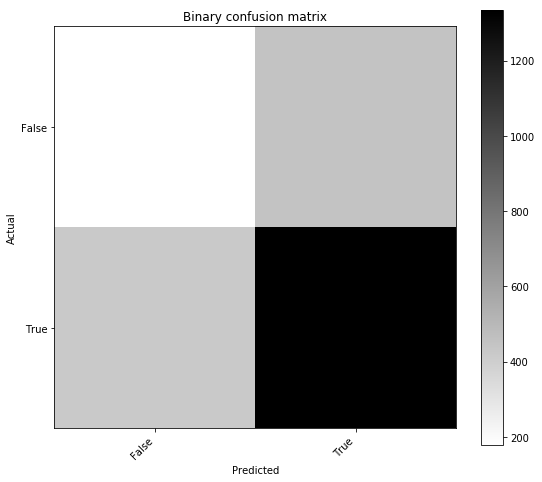

In [244]:
%matplotlib inline
# Confusion Matrix for binary classificaiton

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [245]:
# Plot multiclass confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plot_confusion_matrix(matrix, ['neg_corr', 'no_corr', 'pos_corr'])

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


TypeError: Singleton array 6 cannot be considered a valid collection.

In [246]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.6708054352208135


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# Get ready for some memory-optimisation
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # these cols are memory intensive
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    if str(col) in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')
        
test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

# Create combined gofunc count col
test_set['sumGoFuncs'] = test_set.ChemGoFuncs + test_set.DisGoFuncs
test_set['prodGoFuncs'] = test_set.ChemGoFuncs * test_set.DisGoFuncs



In [ ]:
# Create false pos and false neg col
test_set['false_pos'] = abs(test_set.RoundPredictions - test_set.Correlation).map(lambda x: 0 if x > 200 else x)
test_set['true_pos'] = (test_set.RoundPredictions + test_set.Correlation).map(lambda x: 1 if x==2 else 0)

In [ ]:
test_set.sample(13)

In [ ]:
# Test data for distance correlation
data = [[4,10],[4,12],[6,13]]
zdf = pd.DataFrame(data,columns=['Name','Age'],dtype=np.int64)
type(zdf.Name[1])

In [ ]:
# correlade.dcorr(zdf)
zdf.head().corr()

In [ ]:
#Distance Correlation
correlade.dcorr(test_set.sample(1300)[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']])

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr()

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr(method='spearman')

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'false_pos']].to_csv('predictions.csv', index=False)

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similary

In [ ]:
# df1.head()

In [ ]:
# Calculate out the cosine similarity and see if there's a difference between groups
def cosine_sim (row):
    return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# Compare cosine sim of correlated and uncorrelated groups
print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)